In [1]:
from common_imports import *
from helper import *

# To plot pretty figures
%matplotlib widget

Using TensorFlow backend.


1.13.1


### Train a DNN on the modified dataset

Creating data...


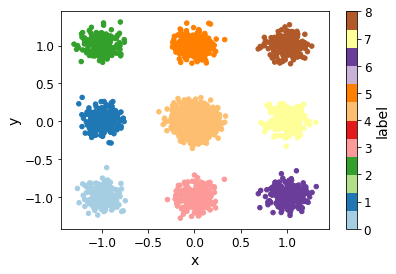

Train Size: (1800, 2)
Test Size: (200,)
Categories: [array([0, 1])]


In [2]:
# Get split returns a generator
# List comprehension is one way to evaluate a generator

original_data, modded_samples, training_labels, original_labels = simulate_blobs(class_size=2000)

# Separating a hold out set that will be used for validation later
X_train, y_train, X_test, y_test, y_original, X_valid, y_valid, y_valid_original = get_train_test_val(modded_samples, original_labels, training_labels)


print("Train Size:", X_train.shape)
print("Test Size:", y_test.shape)


hot_encoder = dfHotEncoder()
hot_encoder.fit(training_labels)
print("Categories:", hot_encoder.categories_)

In [3]:
NUM_FEATURES = X_train.shape[1]
NUM_LABELS = len(hot_encoder.categories_[0])

In [4]:
def build_dnn(num_features, num_labels=3):

#     reset_graph()
    
    keras.backend.clear_session()

    nn = keras.models.Sequential()
    Dense = keras.layers.Dense
    
    # Using He initialization
    he_init = tf.keras.initializers.he_uniform()
    
    nn.add(Dense(units = 16, activation="elu", input_dim=num_features,
                kernel_initializer=he_init))
    nn.add(Dense(units = 16, activation="elu",
                kernel_initializer=he_init))
#     nn.add(Dense(units = 16, activation="elu",
#                 kernel_initializer=he_init))
    nn.add(Dense(units=2, activation= "softmax",
                kernel_initializer=he_init))

#     BCE = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
    nn.compile(loss="categorical_crossentropy",
                  optimizer='sgd',
                  metrics=['accuracy'])
    
    return nn

def train_model(model, X, y, X_test=[], y_test=[], epochs=30, batch_size=20, verbose=1, plot=True):
    
    ZScaler = StandardScaler().fit(X)
    
    X_train = ZScaler.transform(X)
    X_test = ZScaler.transform(X_test)
    
    y_train = hot_encoder.transform(y)
    y_test = hot_encoder.transform(y_test)
    
#     lr_scheduler = keras.callbacks.LearningRateScheduler(exp_decay)
    callback_list = []
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size = batch_size,
                        validation_data=(X_test, y_test), callbacks=callback_list, verbose=verbose)
    
#     if plot: plot_history(history)
    
    return history, ZScaler


In [5]:
nn = build_dnn(NUM_FEATURES)
%time history, Zscaler = train_model(nn, X_train, y_train, X_test, y_test, epochs=50, batch_size=20, verbose=0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
CPU times: user 4.72 s, sys: 1.37 s, total: 6.08 s
Wall time: 2.87 s


## Performing LRP

In [6]:
import innvestigate
import innvestigate.utils as iutils

def perform_analysis(model, analyzer, data, labels=[]):
    analysis = analyzer.analyze(data)
    prediction = model.predict(data)
    
    df_anal = pd.DataFrame(analysis)
    
    return df_anal


scaled_samples = Zscaler.transform(X_valid)

# Getting all the samples that can be correctly predicted
all_samples, _labels, correct_idxs = getCorrectPredictions(nn, scaled_samples, y_valid, enc = hot_encoder)
all_labels = y_valid_original[correct_idxs]


# Stripping the softmax activation from the model
model_w_softmax = nn
model = iutils.keras.graph.model_wo_softmax(model_w_softmax)

# Creating an analyzer
lrp_E = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPEpsilon(model=model, epsilon=1e-3)
lrp_Z = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPZPlus(model=model)
lrp_AB   = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPAlpha2Beta1(model=model)

# perform_analysis(nn,gradient_analyzer,flowers,types)
all_lrp_AB = perform_analysis(model,lrp_AB, all_samples)
all_lrp_E = perform_analysis(model,lrp_E, all_samples)
all_lrp_Z = perform_analysis(model,lrp_Z, all_samples)


Prediction Accuracy
2000/2000 [==============================] - 0s 11us/step
Scores on data set: loss=0.004 accuracy=1.0000
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


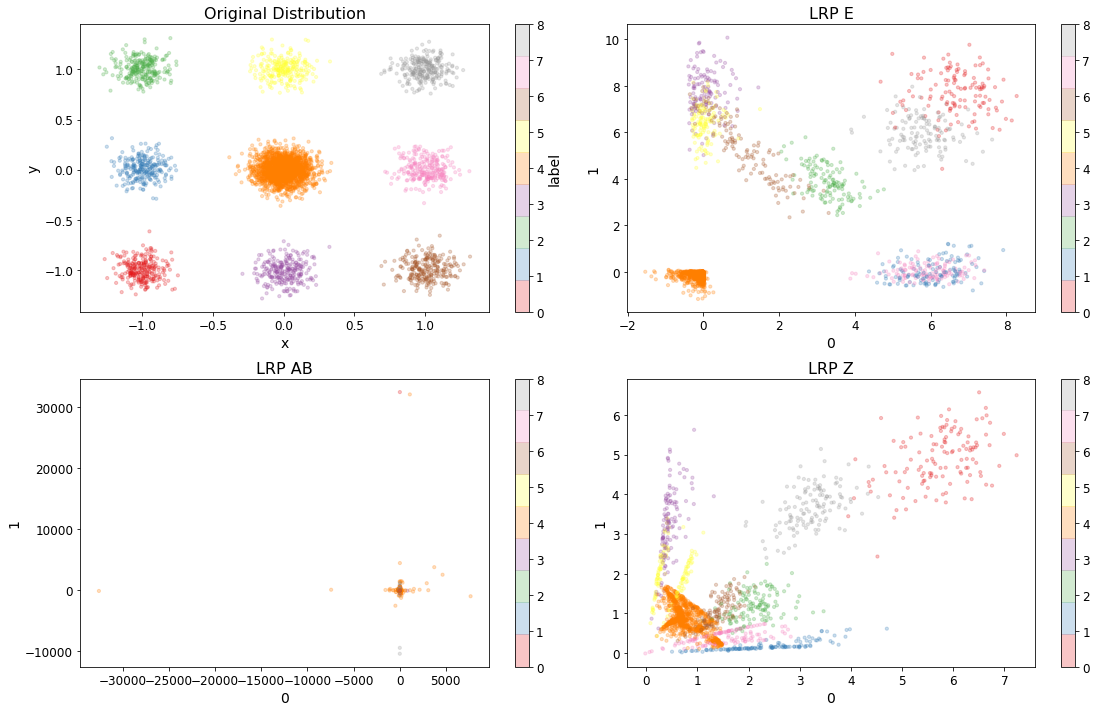

In [7]:
plt.close("Comparison")
fig, axs = plt.subplots(2,2, figsize=(16,10), num="Comparison")
cmap = "Set1" #"Paired"
plot_args = {"kind":"scatter", "x":0,  "y":1, "c":"label", "cmap": cmap, "s":10, "alpha":0.25}

original_data.plot(ax=axs[0][0],title="Original Distribution", **plot_args)

plot_args["c"] = all_labels
all_lrp_E.plot(ax=axs[0][1], title="LRP E", **plot_args)

all_lrp_AB.plot(ax=axs[1][0], title="LRP AB", **plot_args)
all_lrp_Z.plot(ax=axs[1][1], title="LRP Z", **plot_args)

plt.tight_layout()
plt.show()
# plt.savefig(figures_dir+"multiclass_lrp.png")

# Calculating Entropy

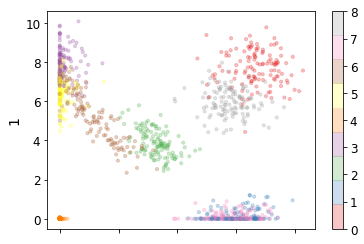

In [14]:
pos_lrp = all_lrp_E.copy()
pos_lrp[pos_lrp<0] = 0
pos_lrp["label"] = all_labels
pos_lrp.plot(**plot_args)

In [125]:
x= pos_lrp[0]
y= pos_lrp[1]
nsamples = len(pos_lrp[0])
nbins = 20

xedges = np.linspace(0,15,nbins+1)
yedges = np.linspace(0,15,nbins+1)

H, xedges, yedges = np.histogram2d(x, y, bins=[xedges,yedges])

In [126]:
grid = pd.DataFrame(H)
density = grid/nsamples
density

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.5000,0.0000,0.0,0.0000,0.0000,0.0005,0.0065,0.0185,0.0350,0.0420,0.0235,0.0110,0.0045,0.0015,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0000,0.0000,0.0,0.0000,0.0000,0.0030,0.0075,0.0070,0.0015,0.0020,0.0010,0.0015,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0000,0.0000,0.0,0.0005,0.0040,0.0065,0.0045,0.0005,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0000,0.0000,0.0,0.0010,0.0080,0.0070,0.0060,0.0010,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0000,0.0000,0.0,0.0050,0.0140,0.0130,0.0040,0.0005,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0030,0.0000,0.0,0.0005,0.0055,0.0010,0.0000,0.0005,0.0010,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0165,0.0010,0.0,0.0000,0.0010,0.0005,0.0015,0.0030,0.0025,0.0025,0.0010,0.0000,0.0005,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0425,0.0005,0.0,0.0000,0.0000,0.0005,0.0030,0.0130,0.0120,0.0055,0.0025,0.0030,0.0005,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0420,0.0030,0.0,0.0000,0.0000,0.0005,0.0020,0.0070,0.0085,0.0070,0.0065,0.0070,0.0010,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0145,0.0015,0.0,0.0000,0.0000,0.0000,0.0015,0.0020,0.0025,0.0055,0.0085,0.0035,0.0005,0.0005,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
probabilities = density.values.flatten()
print(len(probabilities))
probabilities

400


array([0.5   , 0.    , 0.    , 0.    , 0.    , 0.0005, 0.0065, 0.0185,
       0.035 , 0.042 , 0.0235, 0.011 , 0.0045, 0.0015, 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.003 , 0.0075, 0.007 , 0.0015, 0.002 , 0.001 , 0.0015,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.0005, 0.004 , 0.0065, 0.0045, 0.0005,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.001 ,
       0.008 , 0.007 , 0.006 , 0.001 , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.005 , 0.014 , 0.013 , 0.004 , 0.0005,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.003 , 0.    , 0.    , 0.0005,
       0.0055, 0.001 , 0.    , 0.0005, 0.001 , 0.    , 0.    , 0.    ,
      

In [107]:
probabilities.max()

0.5

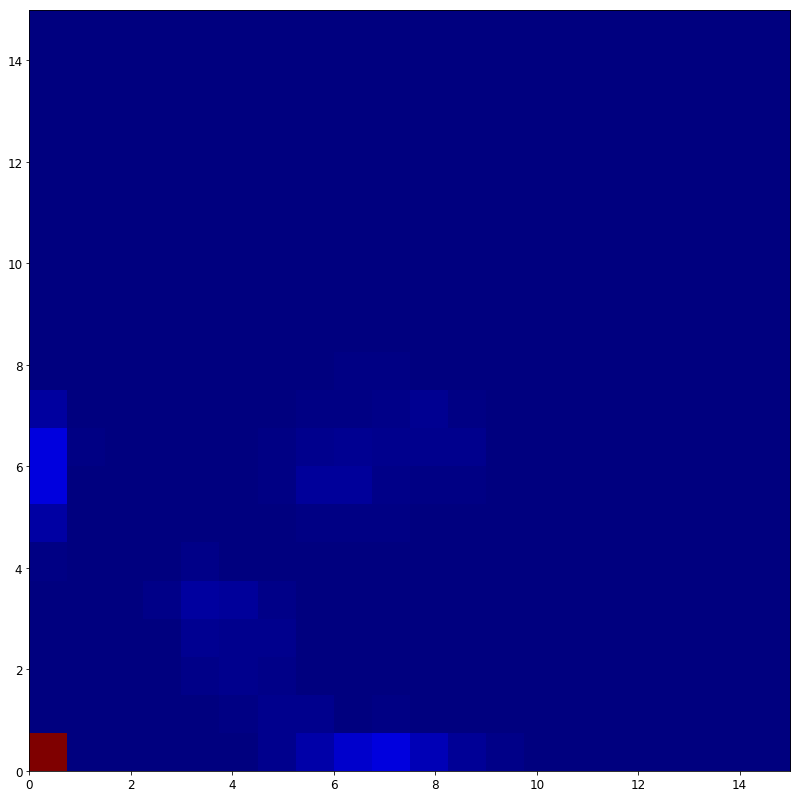

In [128]:
fig, ax = plt.subplots(1, figsize=(14, 14))

ax.imshow(H, interpolation='nearest', origin='low',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="jet")

plt.show()
